In [ ]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# parameters for CSTR
T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
P = np.array([[1060, 22], [22, 0.52]])
T_s = 402
C_As = 1.95

t_final = 0.005
t_step = 1e-4
num_step = 10
num_dims = 4

# parameters for NN
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 500 # number of epochs of each inner SGD
ntrain = 128 # size of training minibatches (K)
threshold = 10

In [ ]:
# functions to vary the parameter values
def generate_new_1000(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_100(x):
    return x + x * np.random.uniform(-1, 1)

def generate_new_5(x):
    return x + x * np.random.uniform(-0.05, 0.05)

In [ ]:
# cstr simulation
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        C_A += dCAdt * t_step
        T += dTdt * t_step

        if (i+1)% 5 == 0:
            C_A_list.append(C_A - C_As)
            T_list.append(T - T_s)

    return C_A_list, T_list

# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [ ]:
# generate data around steady state
def gen_cstr_train(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = T_0
        V_new = V
        F_new = F
        C_A0s_new = C_A0s
        Q_s_new = Q_s
        rho_L_new = rho_L
        C_p_new = C_p
        k_0_new = k_0
        E_new = E
        delta_H_new = delta_H

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-0.5, 0.5, 4, endpoint=True)
        u2_list = np.linspace(-5e1, 5e1, 4, endpoint=True)
        T_initial = np.linspace(380, 420, 10, endpoint=True) - T_s
        CA_initial = np.linspace(1.9, 2, 10, endpoint=True) - C_As

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                x = np.array([CA, T])
                if x @ P @ x < 3:
                    CA_start.append(CA)
                    T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [ ]:
# generate training data around steady state
isOverflow = True
while isOverflow == True:
    try:
        x_all_train, y_all_train = gen_cstr_train(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

Number of training samples:  160


In [ ]:
# generate data in stability region
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new_100(T_0)
        V_new = generate_new_1000(V)
        F_new = generate_new_1000(F)
        C_A0s_new = generate_new_100(C_A0s)
        Q_s_new = generate_new_1000(Q_s)
        rho_L_new = generate_new_5(rho_L)
        C_p_new = generate_new_5(C_p)
        k_0_new = generate_new_5(k_0)
        E_new = generate_new_5(E)
        delta_H_new = generate_new_5(delta_H)

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-3.5, 3.5, 10, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 10, endpoint=True)
        T_initial = np.linspace(300, 600, 40, endpoint=True) - T_s
        CA_initial = np.linspace(0, 6, 40, endpoint=True) - C_As

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                x = np.array([CA, T])
                if x @ P @ x < 372:
                    CA_start.append(CA)
                    T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2), scaler_X, scaler_y, F_new, V_new, C_A0s_new, T_0_new, Q_s_new

In [ ]:
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

Number of training samples:  11800


In [ ]:
# check mean and variance of cstr generated
print(scaler_X_cstr.mean_)
print(scaler_X_cstr.var_)
print(scaler_y_cstr.mean_)
print(scaler_y_cstr.var_)

[ 0.86831812 -0.01258149  0.          0.        ]
[1.53825756e+03 7.35427655e-01 1.01851852e+11 4.99074074e+00]
[ 3.47703996 -0.08839022]
[1.61661161e+03 7.64143434e-01]


In [ ]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_cstr.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_cstr.var_))
    mean_y = to_tensor(scaler_y_cstr.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_cstr.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1] + C_As
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0] + T_s
                C_A0 = x_collocation[:, :, 3] * std_X[3] + mean_X[3] + C_A0s_new_cstr
                Q = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Q_s_new_cstr

                NN_output = NN_output * std_y + mean_y + to_tensor(np.array([T_s, C_As]))

                dCA_first = (NN_output[:, 1:2, 1] - CA_NN_input[:, 0:1]) / (2*t_step*5)
                dT_first = (NN_output[:, 1:2, 0] - T_NN_input[:, 0:1]) / (2*t_step*5)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step*5)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step*5)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step*5)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step*5)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                lossCA = dCA - F_new_cstr / V_new_cstr * (C_A0 - NN_output[:, :, 1]) + k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]**2
                lossCA = K.mean(lossCA**2)

                lossT = dT - F_new_cstr / V_new_cstr * (T_0_new_cstr - NN_output[:, :, 0]) + delta_H / (rho_L * C_p) * k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]**2 - Q / (rho_L * C_p * V_new_cstr)
                lossT = K.mean(lossT**2)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # if epoch % 100 == 0:
        #     print("Training loss: ", loss)

    return model

In [ ]:
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # if epoch % 100 == 0:
        #     print("Training loss: ", loss)

    return model

In [ ]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [ ]:
# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

No. of shots:  1
Testing loss of PI-reptile:  0.0015925319166854024
Testing loss of PI:  0.005731696728616953
Testing loss of data-driven:  0.5794554948806763
Testing loss of transfer learning:  0.6105552315711975
Testing loss of reptile:  0.22382168471813202
No. of shots:  2
Testing loss of PI-reptile:  0.001543366932310164
Testing loss of PI:  0.005365005228668451
Testing loss of data-driven:  0.7598422169685364
Testing loss of transfer learning:  0.4079829752445221
Testing loss of reptile:  0.16703806817531586
No. of shots:  3
Testing loss of PI-reptile:  0.0015050898073241115
Testing loss of PI:  0.00561214005574584
Testing loss of data-driven:  0.41937345266342163
Testing loss of transfer learning:  0.390949010848999
Testing loss of reptile:  0.1456184685230255
No. of shots:  4
Testing loss of PI-reptile:  0.0014738700119778514
Testing loss of PI:  0.0033369152806699276
Testing loss of data-driven:  0.36662980914115906
Testing loss of transfer learning:  0.2587362825870514
Testing

Testing loss of PI-reptile:  0.0015039981808513403
Testing loss of PI:  0.0046273511834442616
Testing loss of data-driven:  0.007420557085424662
Testing loss of transfer learning:  0.013722573406994343
Testing loss of reptile:  0.0029348651878535748
No. of shots:  33
Testing loss of PI-reptile:  0.0014758061151951551
Testing loss of PI:  0.0036116947885602713
Testing loss of data-driven:  0.005744313821196556
Testing loss of transfer learning:  0.011663923971354961
Testing loss of reptile:  0.002949708141386509
No. of shots:  34
Testing loss of PI-reptile:  0.0014135191449895501
Testing loss of PI:  0.003707075258716941
Testing loss of data-driven:  0.006298451218754053
Testing loss of transfer learning:  0.01200177427381277
Testing loss of reptile:  0.0028288604225963354
No. of shots:  35
Testing loss of PI-reptile:  0.0014208168722689152
Testing loss of PI:  0.0038069146685302258
Testing loss of data-driven:  0.007200616877526045
Testing loss of transfer learning:  0.0120975403115153

In [ ]:
# save results
np.savetxt("test_loss_normal_cstr_1.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_cstr_1.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr_1.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_cstr_1.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_1.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

In [ ]:
# rerun for 2nd cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_cstr_2.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_cstr_2.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr_2.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_cstr_2.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_2.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of shots:  1
Testing loss of PI-reptile:  0.0017123316647484899
Testing loss of PI:  0.0054747555404901505
Testing loss of data-driven:  0.7323954105377197
Testing loss of transfer learning:  0.6127074956893921
Testing loss of reptile:  0.22541923820972443
No. of shots:  2
Testing loss of PI-reptile:  0.0016665261937305331
Testing loss of PI:  0.006997573655098677
Testing loss of data-driven:  0.38684970140457153
Testing loss of transfer learning:  0.39760279655456543
Testing loss of reptile:  0.1803954690694809
No. of shots:  3
Testing loss of PI-reptile:  0.0017594692762941122
Testing loss of PI:  0.0057367864064872265
Testing loss of data-driven:  0.2900049686431885
Testing loss of transfer learning:  0.38555023074150085
Testing loss of reptile:  0.1491205245256424
No. of shots:  4
Testing loss of PI-reptile:  0.0016223550774157047
Testing loss of PI:  0.0059130508452653885
Testing loss of data-driven:  0.28772974014282227
Testing loss of trans

Testing loss of PI-reptile:  0.0017747980309650302
Testing loss of PI:  0.003285673912614584
Testing loss of data-driven:  0.00888475775718689
Testing loss of transfer learning:  0.014044063165783882
Testing loss of reptile:  0.003140448359772563
No. of shots:  33
Testing loss of PI-reptile:  0.001968193566426635
Testing loss of PI:  0.005173961166292429
Testing loss of data-driven:  0.00763239711523056
Testing loss of transfer learning:  0.012164859101176262
Testing loss of reptile:  0.003191073425114155
No. of shots:  34
Testing loss of PI-reptile:  0.0019274746300652623
Testing loss of PI:  0.002681670943275094
Testing loss of data-driven:  0.011351163499057293
Testing loss of transfer learning:  0.01228769775480032
Testing loss of reptile:  0.003102613380178809
No. of shots:  35
Testing loss of PI-reptile:  0.0017616836121305823
Testing loss of PI:  0.005643946584314108
Testing loss of data-driven:  0.005137452390044928
Testing loss of transfer learning:  0.012466994114220142
Testi

In [ ]:
# rerun for 3rd cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_cstr_3.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_cstr_3.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr_3.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_cstr_3.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_3.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of shots:  1
Testing loss of PI-reptile:  0.0014834320172667503
Testing loss of PI:  0.00620946753770113
Testing loss of data-driven:  0.9434508681297302
Testing loss of transfer learning:  0.6017882823944092
Testing loss of reptile:  0.2254951000213623
No. of shots:  2
Testing loss of PI-reptile:  0.0016454954165965319
Testing loss of PI:  0.003539338940754533
Testing loss of data-driven:  0.6251851916313171
Testing loss of transfer learning:  0.4058818221092224
Testing loss of reptile:  0.14595401287078857
No. of shots:  3
Testing loss of PI-reptile:  0.001362243085168302
Testing loss of PI:  0.003302809316664934
Testing loss of data-driven:  0.3361760973930359
Testing loss of transfer learning:  0.3759351074695587
Testing loss of reptile:  0.17548155784606934
No. of shots:  4
Testing loss of PI-reptile:  0.0017010582378134131
Testing loss of PI:  0.005582073703408241
Testing loss of data-driven:  0.2967357933521271
Testing loss of transfer lear

Testing loss of PI-reptile:  0.001492908108048141
Testing loss of PI:  0.0036170606035739183
Testing loss of data-driven:  0.008091293275356293
Testing loss of transfer learning:  0.012483305297791958
Testing loss of reptile:  0.0029783640056848526
No. of shots:  33
Testing loss of PI-reptile:  0.001508037792518735
Testing loss of PI:  0.004864344839006662
Testing loss of data-driven:  0.0072724223136901855
Testing loss of transfer learning:  0.011182705871760845
Testing loss of reptile:  0.003050765488296747
No. of shots:  34
Testing loss of PI-reptile:  0.0015170187689363956
Testing loss of PI:  0.0036180138122290373
Testing loss of data-driven:  0.006275174207985401
Testing loss of transfer learning:  0.01137229148298502
Testing loss of reptile:  0.0029344288632273674
No. of shots:  35
Testing loss of PI-reptile:  0.0014553735964000225
Testing loss of PI:  0.003565467894077301
Testing loss of data-driven:  0.012112456373870373
Testing loss of transfer learning:  0.012315597385168076

In [ ]:
# rerun for 4th cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_cstr_4.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_cstr_4.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr_4.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_cstr_4.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_4.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of shots:  1
Testing loss of PI-reptile:  0.0025500799529254436
Testing loss of PI:  0.007868853397667408
Testing loss of data-driven:  1.097232460975647
Testing loss of transfer learning:  0.6115140318870544
Testing loss of reptile:  0.23719094693660736
No. of shots:  2
Testing loss of PI-reptile:  0.002681490033864975
Testing loss of PI:  0.007097771391272545
Testing loss of data-driven:  0.7959780693054199
Testing loss of transfer learning:  0.36837857961654663
Testing loss of reptile:  0.18137706816196442
No. of shots:  3
Testing loss of PI-reptile:  0.0027363027911633253
Testing loss of PI:  0.005712189711630344
Testing loss of data-driven:  0.42216259241104126
Testing loss of transfer learning:  0.36913859844207764
Testing loss of reptile:  0.1609332263469696
No. of shots:  4
Testing loss of PI-reptile:  0.002573267323896289
Testing loss of PI:  0.00650052260607481
Testing loss of data-driven:  0.26978009939193726
Testing loss of transfer le

Testing loss of PI-reptile:  0.002159394323825836
Testing loss of PI:  0.006742557510733604
Testing loss of data-driven:  0.006032305769622326
Testing loss of transfer learning:  0.01426681224256754
Testing loss of reptile:  0.0033236073795706034
No. of shots:  33
Testing loss of PI-reptile:  0.0020397149492055178
Testing loss of PI:  0.00675137247890234
Testing loss of data-driven:  0.00786066334694624
Testing loss of transfer learning:  0.012165346182882786
Testing loss of reptile:  0.003375552361831069
No. of shots:  34
Testing loss of PI-reptile:  0.00220504286698997
Testing loss of PI:  0.004523545037955046
Testing loss of data-driven:  0.00766794616356492
Testing loss of transfer learning:  0.01225190982222557
Testing loss of reptile:  0.003466449212282896
No. of shots:  35
Testing loss of PI-reptile:  0.0020232389215379953
Testing loss of PI:  0.004653445445001125
Testing loss of data-driven:  0.006884329486638308
Testing loss of transfer learning:  0.012169880792498589
Testing 

In [ ]:
# rerun for 5th cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):

    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_cstr_5.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_cstr_5.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr_5.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_cstr_5.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_5.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of shots:  1
Testing loss of PI-reptile:  0.001968756318092346
Testing loss of PI:  0.008023879490792751
Testing loss of data-driven:  0.6771042346954346
Testing loss of transfer learning:  0.6066720485687256
Testing loss of reptile:  0.22288252413272858
No. of shots:  2
Testing loss of PI-reptile:  0.001978631131350994
Testing loss of PI:  0.0058659957721829414
Testing loss of data-driven:  0.7081611752510071
Testing loss of transfer learning:  0.4244752526283264
Testing loss of reptile:  0.14545775949954987
No. of shots:  3
Testing loss of PI-reptile:  0.00200268835760653
Testing loss of PI:  0.006155466660857201
Testing loss of data-driven:  0.18225528299808502
Testing loss of transfer learning:  0.3947931230068207
Testing loss of reptile:  0.1805918961763382
No. of shots:  4
Testing loss of PI-reptile:  0.0013773003593087196
Testing loss of PI:  0.003773372620344162
Testing loss of data-driven:  0.3145900368690491
Testing loss of transfer lear

Testing loss of PI-reptile:  0.001554948161356151
Testing loss of PI:  0.002999415621161461
Testing loss of data-driven:  0.0060373409651219845
Testing loss of transfer learning:  0.01255744881927967
Testing loss of reptile:  0.002852077130228281
No. of shots:  33
Testing loss of PI-reptile:  0.0016214671777561307
Testing loss of PI:  0.0034700946416705847
Testing loss of data-driven:  0.007560924626886845
Testing loss of transfer learning:  0.01134397927671671
Testing loss of reptile:  0.002776489360257983
No. of shots:  34
Testing loss of PI-reptile:  0.0016629156889393926
Testing loss of PI:  0.0029696982819586992
Testing loss of data-driven:  0.012749866582453251
Testing loss of transfer learning:  0.011425384320318699
Testing loss of reptile:  0.0027040804270654917
No. of shots:  35
Testing loss of PI-reptile:  0.0017244110349565744
Testing loss of PI:  0.003606113139539957
Testing loss of data-driven:  0.009925486519932747
Testing loss of transfer learning:  0.011155293323099613


In [ ]:
# get mean and std
test_loss_reptile_cstr_1 = np.loadtxt("test_loss_reptile_cstr_1.txt")
test_loss_reptile_cstr_2 = np.loadtxt("test_loss_reptile_cstr_2.txt")
test_loss_reptile_cstr_3 = np.loadtxt("test_loss_reptile_cstr_3.txt")
test_loss_reptile_cstr_4 = np.loadtxt("test_loss_reptile_cstr_4.txt")
test_loss_reptile_cstr_5 = np.loadtxt("test_loss_reptile_cstr_5.txt")

test_loss_reptile_cstr_mean = np.mean((test_loss_reptile_cstr_1, test_loss_reptile_cstr_2, test_loss_reptile_cstr_3, test_loss_reptile_cstr_4, test_loss_reptile_cstr_5), axis=0)
test_loss_reptile_cstr_std = np.std((test_loss_reptile_cstr_1, test_loss_reptile_cstr_2, test_loss_reptile_cstr_3, test_loss_reptile_cstr_4, test_loss_reptile_cstr_5), axis=0)

test_loss_transfer_cstr_1 = np.loadtxt("test_loss_transfer_cstr_1.txt")
test_loss_transfer_cstr_2 = np.loadtxt("test_loss_transfer_cstr_2.txt")
test_loss_transfer_cstr_3 = np.loadtxt("test_loss_transfer_cstr_3.txt")
test_loss_transfer_cstr_4 = np.loadtxt("test_loss_transfer_cstr_4.txt")
test_loss_transfer_cstr_5 = np.loadtxt("test_loss_transfer_cstr_5.txt")

test_loss_transfer_cstr_mean = np.mean((test_loss_transfer_cstr_1, test_loss_transfer_cstr_2, test_loss_transfer_cstr_3, test_loss_transfer_cstr_4, test_loss_transfer_cstr_5), axis=0)
test_loss_transfer_cstr_std = np.std((test_loss_transfer_cstr_1, test_loss_transfer_cstr_2, test_loss_transfer_cstr_3, test_loss_transfer_cstr_4, test_loss_transfer_cstr_5), axis=0)

test_loss_normal_cstr_1 = np.loadtxt("test_loss_normal_cstr_1.txt")
test_loss_normal_cstr_2 = np.loadtxt("test_loss_normal_cstr_2.txt")
test_loss_normal_cstr_3 = np.loadtxt("test_loss_normal_cstr_3.txt")
test_loss_normal_cstr_4 = np.loadtxt("test_loss_normal_cstr_4.txt")
test_loss_normal_cstr_5 = np.loadtxt("test_loss_normal_cstr_5.txt")

test_loss_normal_cstr_mean = np.mean((test_loss_normal_cstr_1, test_loss_normal_cstr_2, test_loss_normal_cstr_3, test_loss_normal_cstr_4, test_loss_normal_cstr_5), axis=0)
test_loss_normal_cstr_std = np.std((test_loss_normal_cstr_1, test_loss_normal_cstr_2, test_loss_normal_cstr_3, test_loss_normal_cstr_4, test_loss_normal_cstr_5), axis=0)

test_loss_PI_cstr_1 = np.loadtxt("test_loss_PI_cstr_1.txt")
test_loss_PI_cstr_2 = np.loadtxt("test_loss_PI_cstr_2.txt")
test_loss_PI_cstr_3 = np.loadtxt("test_loss_PI_cstr_3.txt")
test_loss_PI_cstr_4 = np.loadtxt("test_loss_PI_cstr_4.txt")
test_loss_PI_cstr_5 = np.loadtxt("test_loss_PI_cstr_5.txt")

test_loss_PI_cstr_mean = np.mean((test_loss_PI_cstr_1, test_loss_PI_cstr_2, test_loss_PI_cstr_3, test_loss_PI_cstr_4, test_loss_PI_cstr_5), axis=0)
test_loss_PI_cstr_std = np.std((test_loss_PI_cstr_1, test_loss_PI_cstr_2, test_loss_PI_cstr_3, test_loss_PI_cstr_4, test_loss_PI_cstr_5), axis=0)

test_loss_PI_reptile_cstr_1 = np.loadtxt("test_loss_PI_reptile_cstr_1.txt")
test_loss_PI_reptile_cstr_2 = np.loadtxt("test_loss_PI_reptile_cstr_2.txt")
test_loss_PI_reptile_cstr_3 = np.loadtxt("test_loss_PI_reptile_cstr_3.txt")
test_loss_PI_reptile_cstr_4 = np.loadtxt("test_loss_PI_reptile_cstr_4.txt")
test_loss_PI_reptile_cstr_5 = np.loadtxt("test_loss_PI_reptile_cstr_5.txt")

test_loss_PI_reptile_cstr_mean = np.mean((test_loss_PI_reptile_cstr_1, test_loss_PI_reptile_cstr_2, test_loss_PI_reptile_cstr_3, test_loss_PI_reptile_cstr_4, test_loss_PI_reptile_cstr_5), axis=0)
test_loss_PI_reptile_cstr_std = np.std((test_loss_PI_reptile_cstr_1, test_loss_PI_reptile_cstr_2, test_loss_PI_reptile_cstr_3, test_loss_PI_reptile_cstr_4, test_loss_PI_reptile_cstr_5), axis=0)

In [ ]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


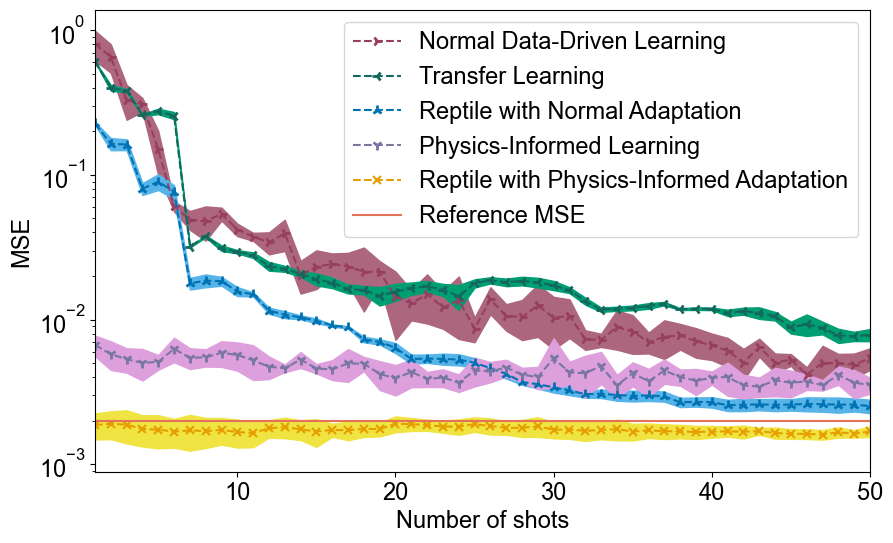

In [ ]:
# Testing
test_loss_reference = [0.002]

size = 50
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_normal_cstr_mean[:size], '--', color='#963F5E', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Normal Data-Driven Learning')
plt.fill_between(x, test_loss_normal_cstr_mean[:size] - test_loss_normal_cstr_std[:size], test_loss_normal_cstr_mean[:size] + test_loss_normal_cstr_std[:size], edgecolor="#AC667E", facecolor="#AC667E")

plt.plot(x, test_loss_transfer_cstr_mean[:size], '--', color='#12685D', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning')
plt.fill_between(x, test_loss_transfer_cstr_mean[:size] - test_loss_transfer_cstr_std[:size], test_loss_transfer_cstr_mean[:size] + test_loss_transfer_cstr_std[:size], edgecolor="#009E73", facecolor="#009E73")

plt.plot(x, test_loss_reptile_cstr_mean[:size], '--', color='#0072B2', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile with Normal Adaptation')
plt.fill_between(x, test_loss_reptile_cstr_mean[:size] - test_loss_reptile_cstr_std[:size], test_loss_reptile_cstr_mean[:size] + test_loss_reptile_cstr_std[:size], edgecolor="#56B4E9", facecolor="#56B4E9")

plt.plot(x, test_loss_PI_cstr_mean[:size], '--', color='#7976A2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_cstr_mean[:size] - test_loss_PI_cstr_std[:size], test_loss_PI_cstr_mean[:size] + test_loss_PI_cstr_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_PI_reptile_cstr_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5.5, markeredgewidth=1.5, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_cstr_mean[:size] - test_loss_PI_reptile_cstr_std[:size], test_loss_PI_reptile_cstr_mean[:size] + test_loss_PI_reptile_cstr_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('cstr_fewshots.pdf')
plt.show()